<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_2brkpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'


'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

['Zonal_eco3_3.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_9.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_15.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_21.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_27.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,377798,73280,2991,6710,121925,3899,168135,12025,51528,2,393,302,7229,54036,101663
1,2,9679,483,566,1933,2590,1559,14459,44091,47927,45719,97738,0,41079,476,22636
2,3,57172,2650,978,57196,24065,34197,15460,99838,709,0,3084,1096,5956,7247,8


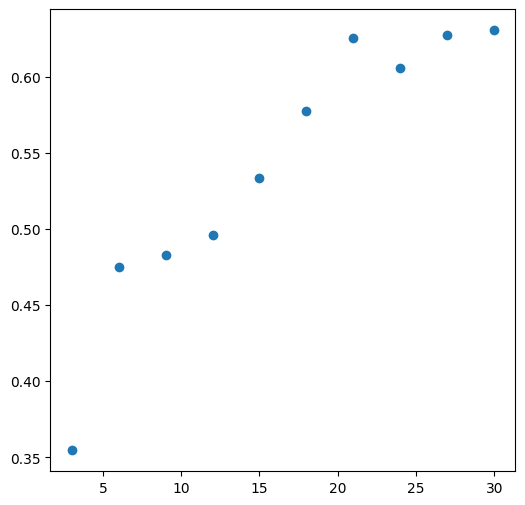

In [6]:

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_dict = {}
for key in keys:
  sorted_dict[key] = df_dict[key]

purity_list = []
for key in sorted_dict:
  df = sorted_dict[key]
  sum = df.iloc[:, 1:].sum().sum()
  max_values_per_row = df.iloc[:, 1:].max(axis=1)
  purity = max_values_per_row.sum()/sum
  purity_list.append(purity)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, purity_list)



/tmp/ipython-input-203426396.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)


6.0
21.0


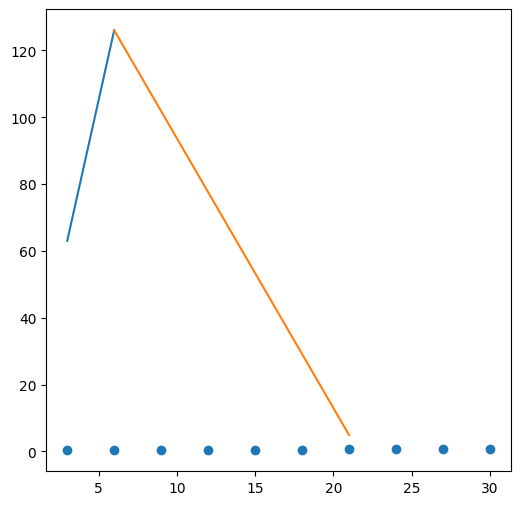

In [8]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b1, b2, m1, c1, m2, c2, m3, c3):
  y = np.zeros_like(x)
  # Segment 1
  mask1 = x <= b1
  y[mask1] = m1 * x[mask1] + c1

  # Segment 2
  mask2 = (x > b1) & (x <= b2)
  y[mask2] = m2 * x[mask2] + c2

  # Segment 3
  mask3 = x > b2
  y[mask3] = m3 * x[mask3] + c3
  return y

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate1 in potential_breakpoints:
    for b_candidate2 in potential_breakpoints:
      try:
        # [breakpoint, slope1, intercept1, slope2, intercept2, slope3, intercept3]
        initial_guess = [b_candidate1, b_candidate2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)
        y_pred = piecewise_linear(x, *params)
        ssr = np.sum((y - y_pred)**2)

        if ssr < min_ssr:
          min_ssr = ssr
          best_breakpoint1, best_breakpoint2  = params[0], params[1]
          best_params = params

      except RuntimeError:
        # Handle cases where curve_fit might fail to converge for a given breakpoint
        print('RuntimeError for case {}'.format(b_candidate1, b_candidate2))
        continue

  return best_breakpoint1, best_breakpoint2, best_params

fitted_b1, fitted_b2, fitted_a1, fitted_c1, fitted_a2, fitted_c2, fitted_a3, fitted_c3 = popt
print(f"Fitted breakpoints: b1={fitted_b1:.2f}, b2={fitted_b2:.2f}")

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in purity_list])

optimal_b1, optimal_b2, optimal_params = find_optimal_breakpoint(x_data, y_data)

print(optimal_b1)
print(optimal_b2)

# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), optimal_b1], [optimal_params[1]*min(x_data) + optimal_params[2], optimal_params[1]*optimal_b1 + optimal_params[2]])
ax.plot([optimal_b1, optimal_b2], [optimal_params[1]*optimal_b1 + optimal_params[2], optimal_params[3]*optimal_b2 + optimal_params[4]])




Fitted breakpoints: b1=0.50, b2=1.00


/tmp/ipython-input-2937646784.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covar = curve_fit(piecewise_linear, x_data, y_data, p0=initial_guess)


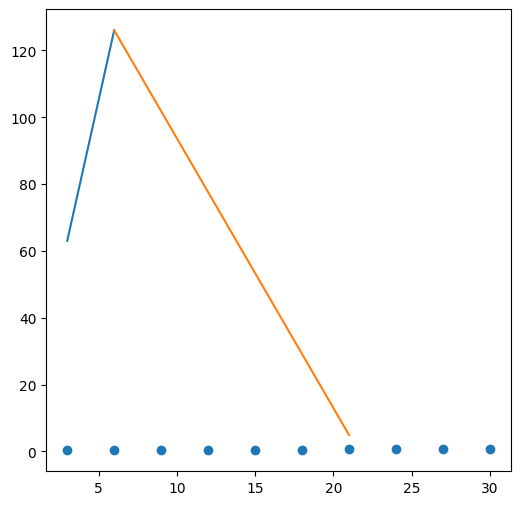

In [9]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b1, b2, m1, c1, m2, c2, m3, c3):
  y = np.zeros_like(x)
  # Segment 1
  mask1 = x <= b1
  y[mask1] = m1 * x[mask1] + c1

  # Segment 2
  mask2 = (x > b1) & (x <= b2)
  y[mask2] = m2 * x[mask2] + c2

  # Segment 3
  mask3 = x > b2
  y[mask3] = m3 * x[mask3] + c3
  return y

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in purity_list])

initial_guess = [0.5, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
popt, covar = curve_fit(piecewise_linear, x_data, y_data, p0=initial_guess)

fitted_b1, fitted_b2, fitted_a1, fitted_c1, fitted_a2, fitted_c2, fitted_a3, fitted_c3 = popt
print(f"Fitted breakpoints: b1={fitted_b1:.2f}, b2={fitted_b2:.2f}")

# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), optimal_b1], [optimal_params[1]*min(x_data) + optimal_params[2], optimal_params[1]*optimal_b1 + optimal_params[2]])
ax.plot([optimal_b1, optimal_b2], [optimal_params[1]*optimal_b1 + optimal_params[2], optimal_params[3]*optimal_b2 + optimal_params[4]])



Optimal Breakpoint: 6.02
Optimal Parameters (b, m1, c1, m2, c2): [ 6.02020202 -0.04511841 -0.23500139 -0.02177028 -0.45839464]


/tmp/ipython-input-4259987560.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


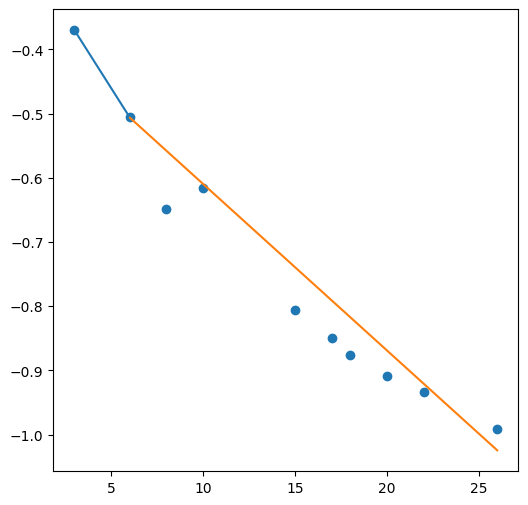

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in entropy_list])

optimal_b, optimal_params = find_optimal_breakpoint(x_data, y_data)

if optimal_b is not None:
  print(f"Optimal Breakpoint: {optimal_b:.2f}")
  print(f"Optimal Parameters (b, m1, c1, m2, c2): {optimal_params}")
else:
  print("Could not find an optimal breakpoint.")


# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), optimal_b], [optimal_params[1]*min(x_data) + optimal_params[2], optimal_params[1]*optimal_b + optimal_params[2]])
ax.plot([optimal_b, max(x_data)], [optimal_params[1]*optimal_b + optimal_params[2], optimal_params[3]*max(x_data) + optimal_params[4]])


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None

  # Define a range of potential breakpoints within the data's x-range
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # Initial guess for parameters (can be refined)
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 1, 0]

      # Fit the piecewise linear function
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)

      # Calculate the sum of squared residuals for this fit
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      continue

  return best_breakpoint, best_params
# Generate some sample data with a known breakpoint
np.random.seed(0)
x_data = np.linspace(0, 10, 50)
y_data_segment1 = 2 * x_data[:25] + 5 + np.random.normal(0, 1, 25)
y_data_segment2 = -1 * x_data[25:] + 20 + np.random.normal(0, 1, 25)
y_data = np.concatenate((y_data_segment1, y_data_segment2))

# Find the optimal breakpoint and parameters
optimal_b, optimal_params = find_optimal_breakpoint(x_data, y_data)

if optimal_b is not None:
  print(f"Optimal Breakpoint: {optimal_b:.2f}")
  print(f"Optimal Parameters (b, m1, c1, m2, c2): {optimal_params}")
else:
  print("Could not find an optimal breakpoint.")



# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([0, optimal_b], [optimal_params[2], optimal_params[1]*optimal_b + optimal_params[2]])

ax.plot([optimal_b, max(x_data)], [optimal_params[1]*optimal_b + optimal_params[2], optimal_params[3]*optimal_b + optimal_params[4]])
